# Тематическая классификация длинных текстов - TFIDF и LogReg

In [ ]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('/content/stepik-dl-nlp')

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [3]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

In [4]:
import nltk
nltk.download('punkt')
from nltk.util import ngrams
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evagolubenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
def make_ngrams(list_sentences):
    
    clean = lambda x: re.sub('[^a-zA-Z]',' ',x.lower())
    probel = lambda x: re.sub(' +',' ',x)
    
    list_sentences = list(map(clean, list_sentences))
    list_sentences = list(map(probel, list_sentences))
    
    list_ngrams = []
    n = 3
    for i in list_sentences:
        i = i.lower().replace('[^a-zA-Z]','').replace(' +',' ')
        sent_ngrams = []
        n_grams = ngrams(i, n)
        for grams in n_grams:
            sent_ngrams.append(''.join(grams))
        list_ngrams.append(sent_ngrams)
    return list_ngrams

In [39]:
test_grams = make_ngrams(test_source.data)
train_grams = make_ngrams(train_source.data)

In [41]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_grams, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных n_gramm', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных n_gramm 10910
[(' ma', 0), (' is', 1), ('it ', 2), ('hat', 3), ('ll ', 4), ('ers', 5), (' wh', 6), ('t r', 7), (' ar', 8), ('ter', 9)]


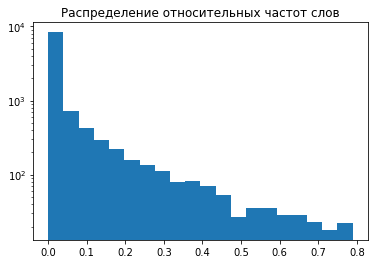

In [42]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [43]:
VECTORIZATION_MODE = 'tfidf'

train_vectors = vectorize_texts(train_grams, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_grams, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 10910)
Размерность матрицы признаков тестовой выборки (11314, 10910)

Количество ненулевых элементов в обучающей выборке 6338101
Процент заполненности матрицы признаков 5.13%

Количество ненулевых элементов в обучающей выборке 4173805
Процент заполненности матрицы признаков 5.08%


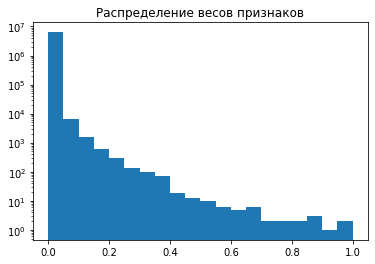

In [44]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [45]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


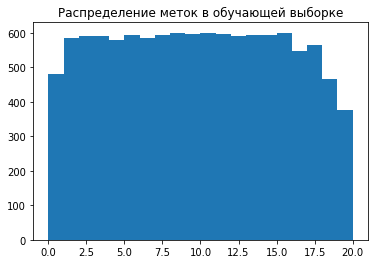

In [46]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

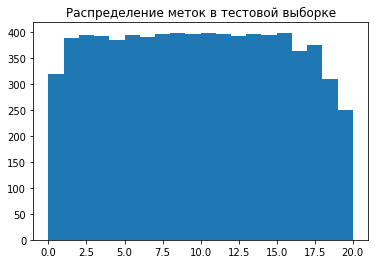

In [47]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [48]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [49]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                                                       patience=5,
                                                                                                                       factor=0.5,
                                                                                                                 verbose=True))

Эпоха 0
Эпоха: 354 итераций, 4.18 сек
Среднее значение функции потерь на обучении 2.4192506135520286
Среднее значение функции потерь на валидации 2.594727742469917
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 3.91 сек
Среднее значение функции потерь на обучении 1.340706202606697
Среднее значение функции потерь на валидации 2.3297550466101047
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.97 сек
Среднее значение функции потерь на обучении 0.8527682659316198
Среднее значение функции потерь на валидации 2.161489104315386
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 4.01 сек
Среднее значение функции потерь на обучении 0.6002110888560613
Среднее значение функции потерь на валидации 2.0433791108050587
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 4.02 сек
Среднее значение функции потерь на обучении 0.44809190234390356
Среднее значение функции потерь на валидации 1.9531017304477045
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.97 сек
Среднее значение функции поте

Эпоха: 354 итераций, 3.93 сек
Среднее значение функции потерь на обучении 0.002762670300609569
Среднее значение функции потерь на валидации 1.3600596565816363

Эпоха 46
Эпоха: 354 итераций, 3.98 сек
Среднее значение функции потерь на обучении 0.002651807410023596
Среднее значение функции потерь на валидации 1.3711227110381854

Эпоха 47
Эпоха: 354 итераций, 3.96 сек
Среднее значение функции потерь на обучении 0.002761485820832152
Среднее значение функции потерь на валидации 1.3569533557204876

Эпоха 48
Эпоха: 354 итераций, 3.92 сек
Среднее значение функции потерь на обучении 0.0025825689387761613
Среднее значение функции потерь на валидации 1.3645213519112538
Модель не улучшилась за последние 10 эпох, прекращаем обучение


## Оценка качества

In [50]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                                        torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()

test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                                        torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

354it [00:02, 143.46it/s]                              
  6%|▋         | 15/235.375 [00:00<00:01, 148.34it/s]

Среднее значение функции потерь на обучении 0.0039345561526715755
Доля верных ответов 0.9992929114371575



236it [00:01, 146.25it/s]                             

Среднее значение функции потерь на валидации 1.3493741750717163
Доля верных ответов 0.6860063728093467


# Альтернативная реализация на scikit-learn

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [13]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.5707153146141617
Доля верных ответов 0.9642036415060986

Среднее значение функции потерь на валидации 2.6933316771751246
Доля верных ответов 0.8177110993096123
